# (Kernel) Ridge Regression
Download the Spotify Tracks Dataset and perform ridge regression to predict the tracks’ popularity. Note that this dataset contains both numerical and categorical features. The student is thus required to follow these guidelines:
- first, train the model using only the numerical features,
- second, appropriately handle the categorical features (for example, with one-hot encoding or other techniques) and use them together with the numerical ones to train the model, in both cases, experiment with different training parameters, 
- use 5-fold cross validation to compute your risk estimates, thoroughly discuss and compare the performance of the model

The student is required to implement from scratch (without using libraries, such as Scikit-learn) the code for the ridge regression, while it is not mandatory to do so for the implementation of the 5-fold cross-validation.

Optional: Instead of regular ridge regression, implement kernel ridge regression using a Gaussian kernel.


## TODOS
 - CV kernel on gamma and alpha on a small number of datapoints (train and test on more datatpoints)
 - Retest and download plots (pick, except for kernel, the same sizes for train and test sets)
 - Fix markdown, comments and structure
 - Add README

# Initialization


Google Colab Cell

In [1]:
if "google.colab" in str(get_ipython()):
    !git clone https://github.com/lukebella/SpotifyRegression.git
    !mv SpotifyRegression/* .
    !rm -fr SpotifyRegression

Insert your Kaggle credentials for downloading the dataset:

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -p ./data -d maharshipandya/-spotify-tracks-dataset
!unzip -n ./data/-spotify-tracks-dataset.zip -d ./data

zsh:1: command not found: kaggle


unzip:  cannot find or open ./data/-spotify-tracks-dataset.zip, ./data/-spotify-tracks-dataset.zip.zip or ./data/-spotify-tracks-dataset.zip.ZIP.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [4]:
# Open the dataset

dataset_file = "data/dataset.csv"

dataset_df = pd.read_csv(dataset_file).drop(columns='Unnamed: 0')
dataset_df = dataset_df.sample(frac = 1, random_state=0).dropna()

dataset_df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
94264,55swcR1hqOlJ45RNoamfDH,Powfu;KNOWN.,tell me your feelings and i won't tell you mine,soda stream sky (feat. KNOWN),52,224825,True,0.609,0.394,0,-10.142,1,0.2090,0.757000,0.000340,0.1270,0.191,172.031,4,sad
6236,4DxJKxGAJMus7zVDOGI3Ab,Summoning,Lugburz,Flight of the Nazgul,20,427000,False,0.110,0.951,9,-9.627,0,0.2620,0.013000,0.384000,0.0626,0.054,76.699,4,black-metal
56,7lLKxcNeJtDTWVRKHovLEC,Aron Wright,Build It Better,Build It Better,51,234473,False,0.526,0.333,4,-13.020,1,0.0314,0.910000,0.168000,0.1110,0.159,94.951,4,acoustic
44601,1euszbbvkUzQzIhZUWFmXG,Highly Suspect,The Boy Who Died Wolf,My Name Is Human,64,258773,True,0.515,0.698,2,-5.572,0,0.0279,0.000057,0.000086,0.0827,0.194,139.960,4,grunge
112474,3aSrj9NKKBlZ3PSg2PFB17,Allame,Toprak,Toprak,40,186283,False,0.770,0.825,7,-4.985,1,0.1960,0.302000,0.000000,0.3620,0.651,136.046,4,turkish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,3lpmIoqpJmiY074Kay62SW,Yemi Alade,Africa Rising Vol.4,Home,0,224000,False,0.555,0.820,7,-2.663,1,0.0782,0.121000,0.000004,0.1290,0.968,113.000,4,dancehall
45891,3V4InT51kenWLTfXC6PfYr,Sonny Chillingworth,"Hawaiian Slack Key Guitar Masters, Vol. 2",Liloa's Mele - Grandson's Lullaby,21,166573,False,0.448,0.150,0,-22.779,1,0.0385,0.772000,0.885000,0.1190,0.125,93.857,4,guitar
42613,1eWNzbwzDFyQ7WTWAWZbnK,Nasum,Helvete,Slaves To the Grind,12,71240,True,0.239,0.961,1,-5.569,1,0.1850,0.000004,0.151000,0.3220,0.210,121.329,5,grindcore
43567,3NiB3v3elOuAy4Ij51F4Sl,Maur,Deep Inside,Deep Inside,62,202633,False,0.637,0.936,11,-5.274,0,0.0371,0.046500,0.000150,0.1040,0.497,126.027,3,groove


# Split the dataset

In [5]:
# Normalize loudness and tempo

loudness_norm = dataset_df["loudness"]
tempo_norm = dataset_df["tempo"]

tempo_norm = tempo_norm/tempo_norm.max(axis=0)

#(abs(min(col)) + i)/max+abs(min(col))

min_loud = abs(loudness_norm.min(axis=0))
max_loud = abs(loudness_norm.max(axis=0))

loudness_norm = (min_loud+loudness_norm)/(min_loud+max_loud)
dataset_df["loudness"] = loudness_norm
dataset_df["tempo"] = tempo_norm

#print(dataset_df["loudness"])

In [6]:
# Create a DataFrame with only track_id and track_genre one-hot encoded
track_genre_df = pd.get_dummies(dataset_df[["track_id", "track_genre"]], columns=['track_genre'], dtype=int)

# Merge the track with the same id
track_genre_df = track_genre_df.groupby("track_id", as_index=False)[[i for i in track_genre_df.columns if i.startswith("track_genre_")]].agg(np.sum)

# Create a partial DataFrame with all feature except track_genre
partial_df = pd.get_dummies(dataset_df.drop(columns=["artists", "album_name", "track_name", 'track_genre']),
                            columns=['explicit', 'key', 'mode', 'time_signature'], dtype=int) \
    .drop_duplicates(subset=['track_id'])

# Merge partial_df and track_genre_df to create the new dataset
categorical_df = pd.merge(partial_df, track_genre_df, on=['track_id'], how='inner').drop(columns="track_id")

# Removed explicit_False because haveing explicit_True this features is useless
categorical_df = categorical_df.drop(columns=["explicit_False"])
categorical_df = categorical_df.rename(columns={"explicit_True": "explicit"})

categorical_df


,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,52,224825,0.609,0.394,0.728576,0.2090,0.757000,0.000340,0.1270,0.191,...,0,0,0,0,0,0,0,0,0,0
1,20,427000,0.110,0.951,0.738102,0.2620,0.013000,0.384000,0.0626,0.054,...,0,0,0,0,0,0,0,0,0,0
2,51,234473,0.526,0.333,0.675342,0.0314,0.910000,0.168000,0.1110,0.159,...,0,0,0,0,0,0,0,0,0,0
3,64,258773,0.515,0.698,0.813107,0.0279,0.000057,0.000086,0.0827,0.194,...,0,0,0,0,0,0,0,0,0,0
4,40,186283,0.770,0.825,0.823965,0.1960,0.302000,0.000000,0.3620,0.651,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,46,186759,0.565,0.630,0.804968,0.0398,0.306000,0.000000,0.7440,0.499,...,0,0,0,0,0,0,0,0,0,0
89736,27,272000,0.546,0.716,0.749533,0.0583,0.603000,0.000000,0.0260,0.913,...,0,0,0,0,0,0,0,0,0,0
89737,0,224000,0.555,0.820,0.866915,0.0782,0.121000,0.000004,0.1290,0.968,...,0,0,0,0,0,0,0,0,0,0
89738,21,166573,0.448,0.150,0.494830,0.0385,0.772000,0.885000,0.1190,0.125,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Create a mask to split the dataset into training set and test set

np.random.seed(0)
mask = np.random.rand(len(categorical_df))<0.7

In [8]:
# Categorical features

train_cat_df = categorical_df[mask]
test_cat_df = categorical_df[~mask]

In [9]:
# Numerical features
numerical_df = categorical_df[["popularity", "duration_ms", "danceability", "energy", "loudness",
                           "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]]

train_num_df = numerical_df[mask]
test_num_df = numerical_df[~mask]

# Defining functions

In [10]:
# Create the hyperplane using regular ridge regression
def ridge_regression(alpha, train_set):
    y = train_set[["popularity"]]
    train_set = train_set.drop(columns='popularity')
    n_rows, n_cols = train_set.shape  # Get the dimensions of the input matrix s
    s_t = train_set.transpose()  # Transpose of matrix s
    
    # Calculate the identity matrix with the appropriate size
    identity = np.identity(n_cols)
    
    # Calculate the ridge regression coefficients using matrix operations
    w = (np.linalg.pinv(alpha * identity + np.dot(s_t, train_set)).dot(s_t)).dot(y) 
    
    # Convert the coefficients to a DataFrame for better presentation
    w_df = pd.DataFrame(w, columns=["Values"], index=train_set.columns)
    
    return w_df

In [11]:
# Predict the popularity of a track x using an hyperplane w
def predict(w, x):
    pred = w.transpose().dot(x.drop(labels='popularity'))[0]
    #pred = max(0, pred)
    #return min(100, pred)
    return pred

In [12]:
# Compute the average square loss of the hyperplane w
def avg_square_loss(w, test_set):
    y = test_set[["popularity"]]
    test_set = test_set.drop(columns='popularity')
    # Convert the DataFrame to a numpy array
    x = test_set.values  
    # Calculate predictions for all rows at once
    predictions = np.dot(x, w)
    
    squared_diff = (predictions -  y)**2
    total_loss = np.sum(squared_diff)
    return total_loss.values[0]/test_set.shape[0]

# Ridge Regression

## Ridge Regression using only numerical features

In [13]:
# Compute the hyperplane for the numerical dataset
predictior_numeric = ridge_regression(0, train_num_df)
predictior_numeric

,Values
duration_ms,-2.968626e-07
danceability,1.197061e+01
energy,-7.251217e+00
loudness,4.210400e+01
speechiness,-1.038704e+01
acousticness,2.464882e+00
instrumentalness,-4.598696e+00
liveness,2.146844e+00
valence,-7.776985e+00
tempo,5.918317e+00


In [14]:
# Predict the first row of the training set
predicted_y = predict(predictior_numeric, train_num_df.iloc[4])
print(f"Predicted y: \t{predicted_y}\nReal y: \t{train_num_df.iloc[4]['popularity']}")

Predicted y: 	34.214380900539346
Real y: 	45.0


In [15]:
# Compute the Average square loss of the hyperplane (numerical)
print("Average square loss: ", avg_square_loss(predictior_numeric, test_num_df))

Average square loss:  414.7969798711406


In [16]:
alphas = 10**np.linspace(10, -2, 100)*0.5

num_train_losses = []
num_test_losses = []

for a in alphas:
    ridge = ridge_regression(a, train_num_df)
    num_train_losses.append(avg_square_loss(ridge, train_num_df))
    num_test_losses.append(avg_square_loss(ridge, test_num_df))

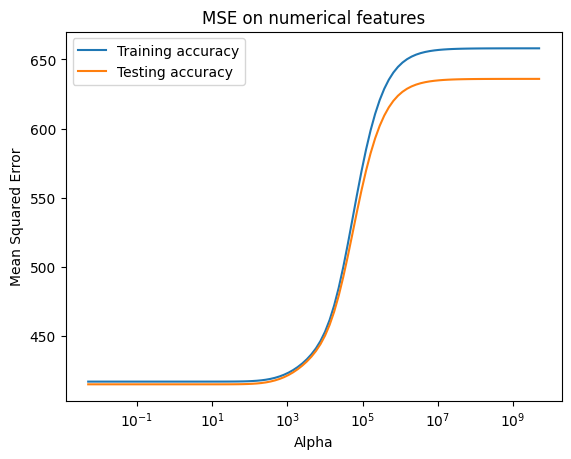

In [17]:
plt.title('MSE on numerical features')
plt.plot(alphas, num_train_losses, label='Training accuracy')
plt.plot(alphas, num_test_losses, label='Testing accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.show()

## Scikitlearn Ridge regression on numerical features


In [18]:
#Scikitlearn Ridge regression

alphas = 10**np.linspace(10, -2, 100)*0.5

sk_num_train_losses = []
sk_num_test_losses = []

for a in alphas:
    clf = Ridge(alpha = a)
    clf.fit(train_num_df.drop(columns='popularity'), train_num_df['popularity'])
    sk_num_train_losses.append(mean_squared_error(train_num_df['popularity'], clf.predict(train_num_df.drop(columns='popularity'))))
    sk_num_test_losses.append(mean_squared_error(test_num_df['popularity'], clf.predict(test_num_df.drop(columns='popularity'))))

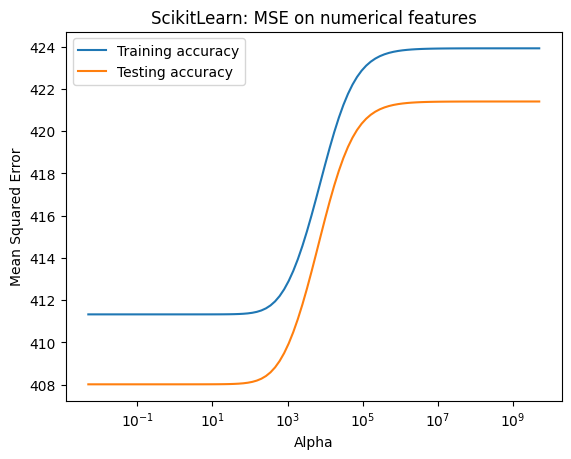

In [19]:
plt.title('ScikitLearn: MSE on numerical features')
plt.plot(alphas, sk_num_train_losses, label='Training accuracy')
plt.plot(alphas, sk_num_test_losses, label='Testing accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.show()

## Ridge regression considering all features
If alpha = 0 --> linear regression

In [20]:
# Compute the hyperplane for the numerical dataset
result_categoric = ridge_regression(0, train_cat_df) #alpha = 0 --> linear regression
result_categoric

,Values
duration_ms,-0.000001
danceability,4.855178
energy,-3.311218
loudness,5.763171
speechiness,-4.727515
...,...
track_genre_techno,4.304148
track_genre_trance,-2.650766
track_genre_trip-hop,-4.438065
track_genre_turkish,1.793361


In [21]:
# Predict the first row of the training set
predicted_y = predict(result_categoric, train_cat_df.iloc[0])
print(f"Predicted y: \t{predicted_y}\nReal y: \t{train_cat_df.iloc[0]['popularity']}")

Predicted y: 	48.43838705608255
Real y: 	52.0


In [22]:
# Compute the Average square loss of the hyperplane (categorical)
print("Average square loss: ", avg_square_loss(result_categoric, test_cat_df))


Average square loss:  273.3458436016838


In [23]:
alphas = 10**np.linspace(10, -2, 100)*0.5

cat_train_losses = []
cat_test_losses = []

for a in alphas:
    ridge = ridge_regression(a, train_cat_df)
    cat_train_losses.append(avg_square_loss(ridge, train_cat_df))
    cat_test_losses.append(avg_square_loss(ridge, test_cat_df))


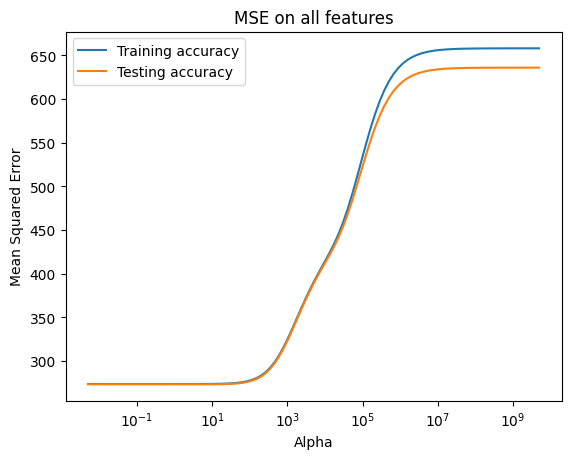

In [24]:
plt.title('MSE on all features')
plt.plot(alphas, cat_train_losses, label='Training accuracy')
plt.plot(alphas, cat_test_losses, label='Testing accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.show()

## ScikitLearn Ridge regression on all features

In [25]:
#Scikitlearn Ridge regression

alphas = 10**np.linspace(10, -2, 100)*0.5

sk_cat_train_losses = []
sk_cat_test_losses = []

for a in alphas:
    clf = Ridge(alpha = a)
    clf.fit(train_cat_df.drop(columns='popularity'), train_cat_df['popularity'])
    sk_cat_train_losses.append(mean_squared_error(train_cat_df['popularity'], clf.predict(train_cat_df.drop(columns='popularity'))))
    sk_cat_test_losses.append(mean_squared_error(test_cat_df['popularity'], clf.predict(test_cat_df.drop(columns='popularity'))))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.76145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.38438e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.58614e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.22577e-17): result may not be acc

In [26]:
clf = Ridge(alpha = 0)
clf.fit(train_cat_df.drop(columns='popularity'), train_cat_df['popularity'])
mean_squared_error(test_cat_df['popularity'], clf.predict(test_cat_df.drop(columns='popularity')))


273.34846984732167

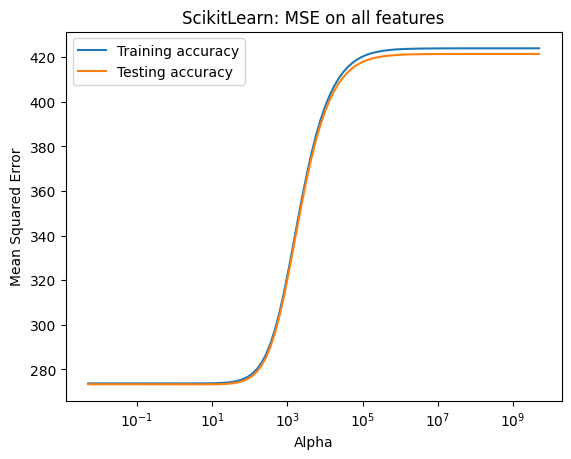

In [27]:
plt.title('ScikitLearn: MSE on all features')
plt.plot(alphas, sk_cat_train_losses, label='Training accuracy')
plt.plot(alphas, sk_cat_test_losses, label='Testing accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.show()

## Numerical vs All features

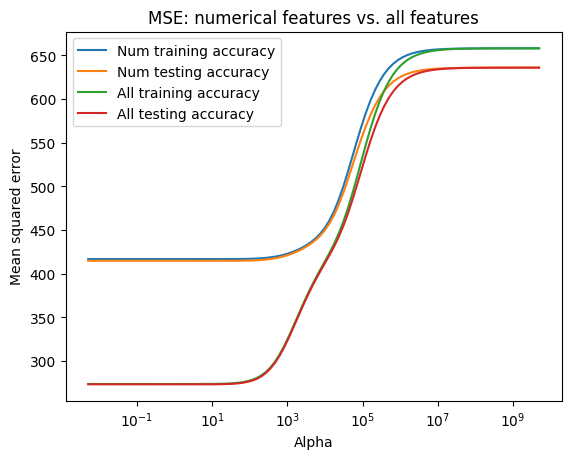

In [28]:
plt.title('MSE: numerical features vs. all features')
plt.plot(alphas, num_train_losses, label='Num training accuracy')
plt.plot(alphas, num_test_losses, label='Num testing accuracy')
plt.plot(alphas, cat_train_losses, label='All training accuracy')
plt.plot(alphas, cat_test_losses, label='All testing accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.show()

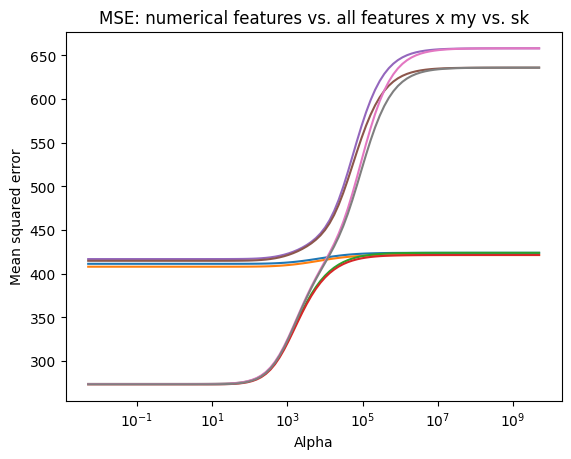

In [29]:
plt.title('MSE: numerical features vs. all features x my vs. sk')
plt.plot(alphas, sk_num_train_losses, label='SK Num training accuracy')
plt.plot(alphas, sk_num_test_losses, label= 'SK Num testing accuracy')
plt.plot(alphas, sk_cat_train_losses, label='SK All training accuracy')
plt.plot(alphas, sk_cat_test_losses, label= 'SK All testing accuracy')
plt.plot(alphas, num_train_losses, label='Num training accuracy')
plt.plot(alphas, num_test_losses, label='Num testing accuracy')
plt.plot(alphas, cat_train_losses, label='All training accuracy')
plt.plot(alphas, cat_test_losses, label='All testing accuracy')
plt.xscale('log')
# plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.show()

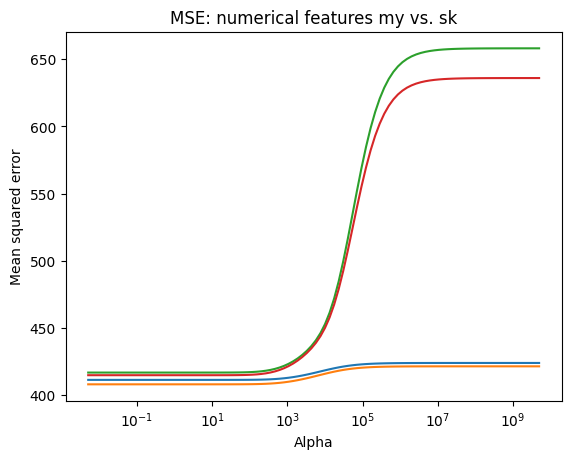

In [30]:
plt.title('MSE: numerical features my vs. sk')
plt.plot(alphas, sk_num_train_losses, label='SK Num training accuracy')
plt.plot(alphas, sk_num_test_losses, label= 'SK Num testing accuracy')
# plt.plot(alphas, sk_cat_train_losses, label='SK All training accuracy')
# plt.plot(alphas, sk_cat_test_losses, label= 'SK All testing accuracy')
plt.plot(alphas, num_train_losses, label='Num training accuracy')
plt.plot(alphas, num_test_losses, label='Num testing accuracy')
# plt.plot(alphas, cat_train_losses, label='All training accuracy')
# plt.plot(alphas, cat_test_losses, label='All testing accuracy')
plt.xscale('log')
# plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.show()

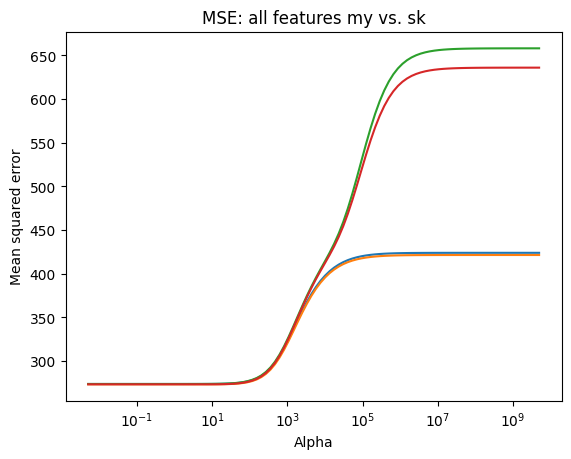

In [31]:
plt.title('MSE: all features my vs. sk')
# plt.plot(alphas, sk_num_train_losses, label='SK Num training accuracy')
# plt.plot(alphas, sk_num_test_losses, label= 'SK Num testing accuracy')
plt.plot(alphas, sk_cat_train_losses, label='SK All training accuracy')
plt.plot(alphas, sk_cat_test_losses, label= 'SK All testing accuracy')
# plt.plot(alphas, num_train_losses, label='Num training accuracy')
# plt.plot(alphas, num_test_losses, label='Num testing accuracy')
plt.plot(alphas, cat_train_losses, label='All training accuracy')
plt.plot(alphas, cat_test_losses, label='All testing accuracy')
plt.xscale('log')
# plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.show()

Text(0.5, 1.0, 'ScikitLearn')

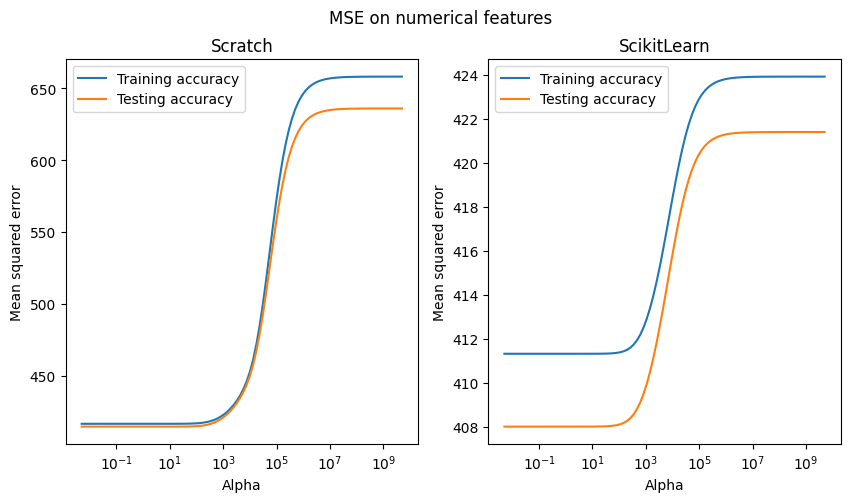

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('MSE on numerical features')
fig.set_size_inches(10,5)

ax1.plot(alphas, num_train_losses, label='Training accuracy')
ax1.plot(alphas, num_test_losses, label='Testing accuracy')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Mean squared error')
ax1.legend()
ax1.set_title("Scratch")

ax2.plot(alphas, sk_num_train_losses, label='Training accuracy')
ax2.plot(alphas, sk_num_test_losses, label='Testing accuracy')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Mean squared error')
ax2.legend()
ax2.set_title("ScikitLearn")


Text(0.5, 1.0, 'ScikitLearn')

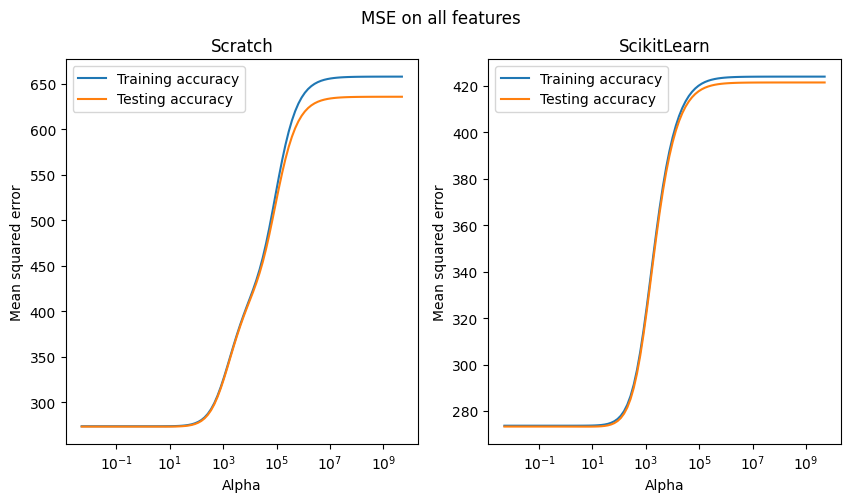

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('MSE on all features')
fig.set_size_inches(10, 5)

ax1.plot(alphas, cat_train_losses, label='Training accuracy')
ax1.plot(alphas, cat_test_losses, label='Testing accuracy')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Mean squared error')
ax1.legend()
ax1.set_title("Scratch")

ax2.plot(alphas, sk_cat_train_losses, label='Training accuracy')
ax2.plot(alphas, sk_cat_test_losses, label='Testing accuracy')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Mean squared error')
ax2.legend()
ax2.set_title("ScikitLearn")


# (Nested) Cross Validation

In [34]:
def cross_validation(k, dataset, alphas):

    # Return a df from an arraty of df excepr the i-th
    def get_set_except_i(dataset_array, i):
        return pd.concat(dataset_array[j] for j in range(len(dataset_array)) if i!=j)
    
    # Split the dataset into k parts
    dataset_array = np.array_split(dataset, k)
    
    losses = []

    for i in range(k):
        # In the i-th iteration, Si is the test and S\Si is the training
        test_cv = dataset_array[i]
        train_cv = get_set_except_i(dataset_array, i)

        # Split the training set into a new training set and a valid set (nested CV)
        train_cv_array = np.array_split(train_cv, k-1)
        dev_cv = train_cv_array[0]
        nested_cv = get_set_except_i(train_cv_array, 0)
        
        # Find the best hyperparameter of your alphas
        loss = float("inf")
        alpha = 0
        for a in alphas:
            predictor = ridge_regression(a, nested_cv)

            local_loss = avg_square_loss(predictor, dev_cv)
            if loss > local_loss:
                loss = local_loss
                alpha = a
                
        # Compute k predictors and their losses
        prediction = ridge_regression(alpha, train_cv)
        losses.append(avg_square_loss(prediction, test_cv))

    #Find the avg loss of the predictors
    return np.mean(losses), prediction, alpha

In [35]:
K = 5
alphas = 10**np.linspace(10, -2, 100)*0.5
loss_cv, pred_cv, a_cv = cross_validation(K, categorical_df, alphas)
print("Average loss with nested CV: ", loss_cv)
print("Best alpha with nested CV: ", a_cv)

#Experiment with alpha achieved by CV
prediction = ridge_regression(a_cv, train_cat_df.sample(7500, random_state=0))
print(avg_square_loss(prediction, test_cat_df.sample(2500, random_state=0)))


# no shuffle
# Average loss with nested CV:  499.37945948919185
# Best alpha with nested CV:  201.85086292982749

# shuffle
# Average loss with nested CV:  369.03813448560055
# Best alpha with nested CV:  0.005

# shuffle + group by track_genre
# Average loss with nested CV:  275.4156551707504
# Best alpha with nested CV:  5.361336110051605

# Train 7500 Test 2500
# Average loss with nested CV:  276.16544359716806 (whole train set)
# Best alpha with nested CV:  5.361336110051605
# 292.374509533854


Average loss with nested CV:  275.3960529276182
Best alpha with nested CV:  5.361336110051605
292.40645083221796


## ScikitLearn Ridge CV

In [36]:
alphas = 10**np.linspace(10, -2, 100)*0.5

clf = RidgeCV(alphas=alphas, cv=5)
clf.fit(categorical_df.drop(columns='popularity'),categorical_df['popularity'])

sk_loss_cv = mean_squared_error(categorical_df['popularity'], clf.predict(categorical_df.drop(columns='popularity')))
sk_loss_cv

# no shuffle
# 392.4801619277324

# shuffle
# 367.9301797580014

# shuffle + group by track_genre
# 273.356488100245


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.68246e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.79368e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.35089e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.65487e-17): result may not be acc

273.356488100245

# Kernel Ridge Regression


Function for calculating thorugh permutations gamma.

In [37]:
def avg_norm(dataset, n_samples):
    d = dataset.sample(n = n_samples, random_state = 0).values
    norm = 0
    for i in range(n_samples):
        for j in range(i,n_samples):
            norm += (np.linalg.norm(d[i] - d[j]))**2
    return norm/n_samples

In [38]:
norm_list = []
for i in [100, 500, 1000, 5000, 10000]:
    norm_list.append(avg_norm(categorical_df, i))

norm_list
avg_gamma = norm_list[-1]

#note that the more samples I examine, the more the distances increase

|Samples|Average Norm|
|-|-|
|100|1269478675158.0928|
|500|3679612519086.3193|
|1000|7318783476432.996|
|5000|40653386738772.76|
|10000|105926124925237.1|


### These kernel functions take the hyperparameter gamma as input.

In [39]:
def gaussian_kernel(gamma, v1, v2):
    norm = np.square(np.linalg.norm(v1 - v2))
    return np.exp((norm)/-(2 * (gamma))) # maybe we need to add **2 to gamma (or **0.5 to ScikitLearn RBF)


def kernel_ridge_regression(dataset, alpha, gamma):
    y = dataset["popularity"]
    dataset_values = dataset.drop(columns='popularity').values
    n_samples = dataset.shape[0]

    kernel = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            kernel[i, j] = gaussian_kernel(gamma, dataset_values[i], dataset_values[j])

    # we consider half of the datapoints since it is the 'specular'
    kernel = np.triu(kernel, 1) + kernel.transpose()
    
    identity = np.identity(n_samples)

    #alpha is the best hyperparmeter achieved by the cv process above
    #w = y.transpose() @ np.linalg.inv((alpha * identity + kernel)) 
    w = np.linalg.solve(alpha * identity + kernel, y)
 
    w_df = pd.DataFrame(w, columns=['weights'])
    return w_df


def kernel_predict(w, dataset, x, gamma):
    x_values = x.drop(labels='popularity').values
    dataset_values = dataset.drop(columns='popularity').values
    kernel_values = np.array([gaussian_kernel(gamma, x_values, x_i) for x_i in dataset_values])
    prediction = w['weights'] @ kernel_values
    # prediction = max(0, prediction)  # ReLU
    # prediction = min(100, prediction)
    return prediction


def kernel_avg_square_loss(w, train_set, test_set, gamma):
    y = test_set[["popularity"]]
    predictions = test_set.apply(lambda r: kernel_predict(w, train_set, r, gamma), 1)
    squared_diff = (predictions - y.transpose())**2
    return np.mean(squared_diff, axis=1)[0]


### Test Kernel only on numerical features

In [41]:
# Test kernel on numerical features
train_set = train_num_df.sample(7500, random_state=0)
test_set = test_num_df.sample(2500, random_state=0)
x = numerical_df.iloc[90]

gamma = avg_norm(train_set, train_set.shape[0])
w = kernel_ridge_regression(train_set, 1, gamma)

print(x['popularity'])
print(kernel_predict(w, train_set, x, gamma))

kernel_loss = kernel_avg_square_loss(w, train_set, test_set, gamma)
print("AVG Square loss: ", kernel_loss)
print("AVG loss: ", kernel_loss**(1/2))

52.0
32.85952515909548
AVG Square loss:  429.97604884348056
AVG loss:  20.735863831619856


### Test Kernel on all features

In [42]:
# Test kernel on all features

train_set = train_cat_df.sample(7500, random_state=0)
test_set = test_cat_df.sample(2500, random_state=0)
x = categorical_df.iloc[90]

gamma = avg_norm(train_set, train_set.shape[0])
w = kernel_ridge_regression(train_set, 1, gamma)

print(x['popularity'])
print(kernel_predict(w, train_set, x, gamma))

kernel_loss = kernel_avg_square_loss(w, train_set, test_set, gamma)
print("AVG Square loss: ", kernel_loss)
print("AVG loss: ", kernel_loss**(1/2))

# 1000 train on all test set
# AVG Square loss:  556.4917928496213
# AVG loss:  23.590078271375475

# 6000 train 1000 test
# AVG Square loss:  502.54840986535186
# AVG loss:  22.41759152686461

52.0
32.859525159105374
AVG Square loss:  429.97604884328376
AVG loss:  20.735863831615113


## ScikitLearn Kernel Ridge regression

In [43]:
#Scikitlearn Kernel Ridge regression on all features

train_set = train_cat_df.sample(7500, random_state=0)
test_set = test_cat_df.sample(2500, random_state=0)

# test with linear kernel
clf = KernelRidge(kernel=RBF(avg_gamma), alpha=a_cv, gamma=avg_gamma)
clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])
sk_kernel_train_loss = mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity')))
sk_kernel_test_loss = mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity')))
print("Train ", sk_kernel_train_loss)
print("Test ", sk_kernel_test_loss)

# train 6000 test 1000
# Train  488.59196560321664
# Test  502.69249755574214

Train  424.15037803895166
Test  430.50407137813846


## Kernel Cross Validation

In [44]:
alphas = 10. ** np.arange(-2, 5)
# gammas = 10. ** np.arange(0, 5)
gammas = np.linspace(1, norm_list[-1]*2, 5)
print(alphas, gammas)


[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04] [1.00000000e+00 5.29630625e+13 1.05926125e+14 1.58889187e+14
 2.11852250e+14]


In [45]:
# train 5000

# alphas
# gammas

# re train 20000
# re test  4000


def kernel_cross_validation(k, dataset, alpha, gammas):
    # Return a df from an arraty of df excepr the i-th
    def get_set_except_i(dataset_array, i):
        return pd.concat(dataset_array[j] for j in range(len(dataset_array)) if i!=j)

    # Split the dataset into k parts
    dataset_array = np.array_split(dataset, k)

    losses = []

    for i in range(k):
        # In the i-th iteration, Si is the test and S\Si is the training
        test_cv = dataset_array[i]
        train_cv = get_set_except_i(dataset_array, i)

        # Split the training set into a new training set and a valid set (nested CV)
        train_cv_array = np.array_split(train_cv, k-1)
        dev_cv = train_cv_array[0]
        nested_cv = get_set_except_i(train_cv_array, 0)

        # Find the best hyperparameter of your alphas
        loss = float("inf")
        gamma = 0
        for g in gammas:
            predictor = kernel_ridge_regression(nested_cv, alpha, g)

            local_loss = kernel_avg_square_loss(predictor, nested_cv, dev_cv, g)
            if loss > local_loss:
                loss = local_loss
                gamma = g

        # Compute k predictors and their losses
        prediction = kernel_ridge_regression(train_cv, alpha, gamma)
        losses.append(kernel_avg_square_loss(prediction, train_cv, test_cv, gamma))

    #Find the avg loss of the predictors
    return np.mean(losses), prediction, gamma

In [46]:
K = 5
kcv_size = 1000
kcv_df = categorical_df.sample(kcv_size, random_state=0)
kernel_cv_losses = []
kernel_cv_predictor = []
kernel_cv_gamma = []
for a in alphas:
    tmp = kernel_cross_validation(K, kcv_df, a, gammas)
    kernel_cv_losses.append(tmp[0])
    kernel_cv_predictor.append(tmp[1])
    kernel_cv_gamma.append(tmp[2])

In [47]:
print(alphas)
print(kernel_cv_gamma)
print(kernel_cv_losses)
ind = kernel_cv_losses.index(min(kernel_cv_losses))
best_alpha = alphas[ind]
best_gamma = kernel_cv_gamma[ind]

print(best_gamma)



[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[52963062462619.3, 52963062462619.3, 52963062462619.3, 52963062462619.3, 52963062462619.3, 211852249850474.2, 211852249850474.2]
[433.38952733336885, 433.4884020226776, 433.6312688539492, 433.8963706350467, 446.1480311910962, 746.4662127322014, 1303.2515393284586]
52963062462619.3


Text(0.5, 1.0, 'Hyperparameter tuning in Kernel Ridge regression')

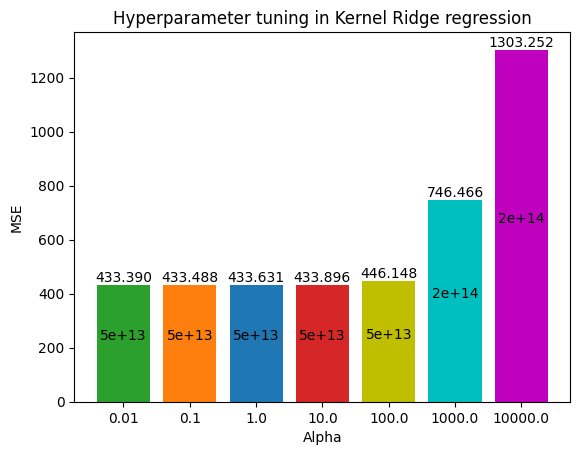

In [48]:
bar_alpha = [f'{i}' for i in alphas] 
bar_name = [str(i) for i in kernel_cv_gamma]
bar_value = kernel_cv_losses
bar_colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red', 'y', 'c', 'm']

bars = plt.bar(bar_alpha, bar_value, label=bar_name, color=bar_colors)
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')
    plt.text(b.get_x() + b.get_width() / 2.0, height/2, f'{float(b.get_label()):.1}', ha='center', va='bottom')

plt.ylabel('MSE')
plt.xlabel('Alpha')
plt.title('Hyperparameter tuning in Kernel Ridge regression')
#plt.legend() #for report, comment this line and specify that the gamma value is the same

In [49]:
#Train and test Kernel CV with bigger set sizes
train_cv = train_cat_df.sample(7500, random_state=0)
test_cv = test_cat_df.sample(2500, random_state=0)
prediction = kernel_ridge_regression(train_cv, best_alpha, best_gamma)
kernel_avg_square_loss(prediction, train_cv, test_cv, best_gamma)

# 502.50438422998735 with 6000 and 100
# 429.4966147137057 with 7500 and 2500

429.4966147137057

# CV vs. Kernel Ridge regression

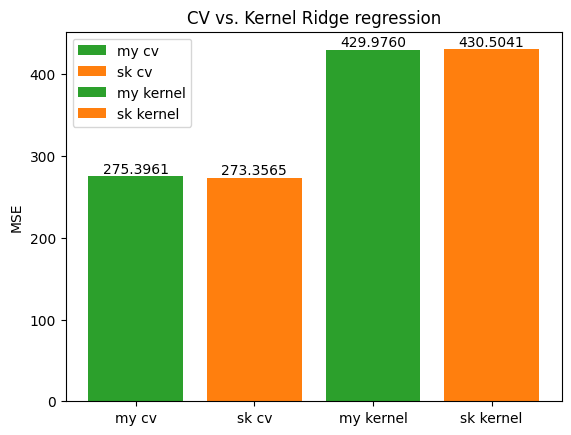

In [50]:
bar_name = ['my cv', 'sk cv', 'my kernel', 'sk kernel']
bar_value = [loss_cv, sk_loss_cv, kernel_loss, sk_kernel_test_loss]
bar_colors = ['tab:green', 'tab:orange', 'tab:green', 'tab:orange']

bars = plt.bar(bar_name, bar_value, label=bar_name, color=bar_colors)
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
plt.ylabel('MSE')
plt.title('CV vs. Kernel Ridge regression')
plt.legend()